Not needed anymore as I found the error why Vmax for the Sim did not behave like the Cosmos data. The error was that I used the magnitude error and not the magnitude to calculate the weights. 

Furthermore, to continue this notebook properly, I need to figure out how to do the galaxy type separation. Will did this in the `Galaxies_paper_validation_plots_noDES` notebook by using the UVJ type. I do not know how to get this columns and I doubt it will be worth the effort.

In [58]:
import numpy as np
import skypy.galaxies
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import speclite.filters as spec
from chainconsumer import ChainConsumer
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from astropy.modeling.models import Linear1D, Exponential1D
import sys

sys.path.insert(1, 'skypy_x/galaxies_paper')

import gaussian_error

plt.rc('font',**{'family':'serif','size':14})
plt.rc('text', usetex=True)

In [34]:
# parameters for sim
a_m_SF = -0.439
b_m_SF = -20.623
a_phi_SF = -0.088
b_phi_SF = 0.004245
a_m_Q = -0.697
b_m_Q = -20.372
a_phi_Q = -0.836
b_phi_Q = 0.005169
a_phi_inv_SF = -11.36364 #!numpy.divide [1., $a_phi_SF]
a_phi_inv_Q = -1.19617 #!numpy.divide [1., $a_phi_Q]
alpha_SF = -1.3
alpha_Q = -0.5

cosmology = FlatLambdaCDM(Om0=0.3, H0=70)
mag_lim = 30
sky_area = Quantity(1.27, 'deg2')
filters = {'hsc': [ 'hsc2017-g', 'hsc2017-r', 'hsc2017-i', 'hsc2017-z', 'hsc2017-y' ],
          'vista': [ 'filters/vista-Y.ecsv', 'filters/vista-J.ecsv', 'filters/vista-H.ecsv', 'filters/vista-Ks.ecsv' ]}
bands_hsc = 'grizy'
bands_vista = 'YJHK'
mag_limits = {'hsc': [27.8, 27.4, 27.1, 26.6, 25.6], 
             'vista': [24.5, 24.5, 24.2, 23.75]}

weight_sf = [3.47e+09, 3.31e+06, 2.13e+09, 1.64e+10, 1.01e+09]
weight_q = [3.84e+09, 1.57e+06, 3.91e+08, 4.66e+10, 3.03e+07]

alpha0_sf = [1.9946549, 1.99469164, 1.99461187, 1.9946589, 1.99463069]
alpha0_q = [1.62158197, 1.62137391, 1.62175061, 1.62159144, 1.62165971]
alpha1 = [0, 0, 0, 0, 0]

rykoff_parameters_hsc = np.array([[3.171762, 0.66012], [2.49441, 0.80837], [1.928186, 0.95754], [1.778944, 0.99381], [1.771616, 1.017114]])
rykoff_parameters_vista = np.array([[2.07, 0.666], [2.07, 0.666], [1.801, 0.726], [1.896, 0.688]])

In [48]:
cosmos = pyfits.open("/Users/philipp/Documents/PhD/Data/COSMOS2020_Classic_processed.fits")[1].data
mask = np.where((23.9-2.5*np.log10(cosmos['UVISTA_Ks_FLUX_APER3'])<25.5)&(cosmos['photoz']>0))[0]
cosmos = cosmos[mask]
cosmos_abs_mag = pyfits.open("/Users/philipp/Documents/PhD/Data/Cosmos_Classic_absolute_mags.fits")[1].data['AbsMag Interp']
print(len(cosmos))

mask = np.where((cosmos['photoz']>0) &
                (cosmos['photoz']<4.5) &
                (cosmos['lp_type']==0))[0]
cosmos = cosmos[mask]
cosmos_abs_mag = cosmos_abs_mag[mask]
print(len(cosmos))

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


441277
435808


In [49]:
M_sf = skypy.galaxies.luminosity.schechter_lf_magnitude(cosmos['photoz'], Linear1D(a_m_SF, b_m_SF),
                                                        alpha_SF, mag_lim, cosmology)
print(len(M_sf))

coeff_sf = skypy.galaxies.spectrum.dirichlet_coefficients(np.zeros_like(M_sf), alpha0_sf, alpha1, weight_sf)
sm_sf = skypy.galaxies.spectrum.kcorrect.stellar_mass(coeff_sf, M_sf, 'bessell-B')
m_hsc_true_sf = skypy.galaxies.spectrum.kcorrect.apparent_magnitudes(coeff_sf,cosmos['photoz'], filters['hsc'], 
                                                                     cosmology, stellar_mass=sm_sf)
m_hsc_sim_sf, hsc_sigma_sf = gaussian_error.gaussian_error_magnitude(m_hsc_true_sf, mag_limits['hsc'], 
                                                                             rykoff_parameters_hsc, 30)
m_vista_true_sf = skypy.galaxies.spectrum.kcorrect.apparent_magnitudes(coeff_sf, cosmos['photoz'], filters['vista'], 
                                                                       cosmology, stellar_mass=sm_sf)
m_vista_sim_sf, vista_sigma_sf = gaussian_error.gaussian_error_magnitude(m_vista_true_sf, mag_limits['vista'], 
                                                                             rykoff_parameters_vista, 30)

435808


In [54]:
# selection cut Ks band mag < 24.5
mask_cosmos = (23.9-2.5*np.log10(cosmos['UVISTA_Ks_FLUX_APER3'])<24.5)
mask_sim = (m_vista_true_sf[:,3] + m_vista_sim_sf[:,3]) < 24.5         

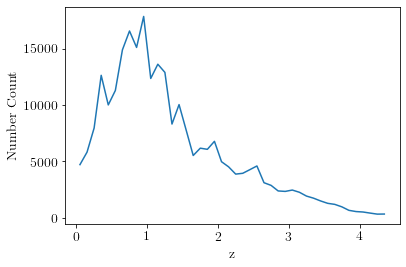

In [55]:
# plot redshift distribution
bins_redshift =np.arange(0,4.5,0.1)
bin_centers_redshift = bins_redshift[:-1] + (bins_redshift[-1]-bins_redshift[0])/(2*len(bins_redshift))
hist, _ = np.histogram(cosmos['photoz'][mask_cosmos], bins=bins_redshift)
plt.plot(bin_centers_redshift, hist)
plt.xlabel("z")
plt.ylabel('Number Count')
plt.show()

### Compare Apparent Magnitude Distribution

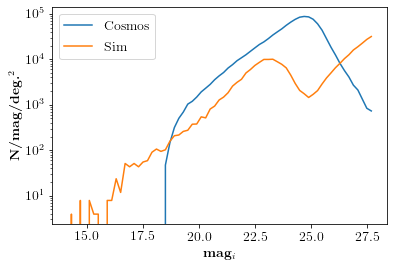

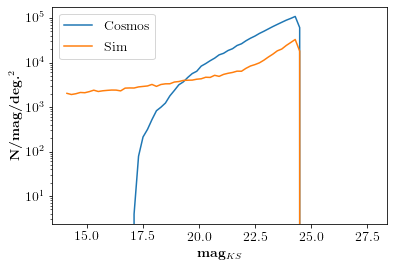

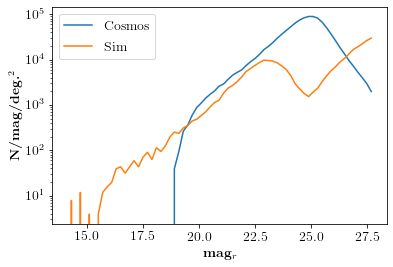

In [57]:
bins_app_mag = np.arange(14,28,0.2)
bin_centers_app_mag = bins_app_mag[:-1] + (bins_app_mag[-1]-bins_app_mag[0])/(2*len(bins_app_mag))

# i-band
hist_cosmos, _ = np.histogram(cosmos['HSC_i_MAG_APER3'][mask_cosmos], bins=bins_app_mag, density=False)
hist_sim, _ = np.histogram(m_hsc_true_sf[:,2][mask_sim] + m_hsc_sim_sf[:,2][mask_sim] , bins=bins_app_mag, density=False)
plt.plot(bin_centers_app_mag, hist_cosmos/1.27/0.2, label='Cosmos')
plt.plot(bin_centers_app_mag, hist_sim/1.27/0.2, label='Sim')
plt.legend()
plt.xlabel(r'\textbf{mag$_i$}')
plt.ylabel(r'\textbf{N/mag/deg.$^2$}')
plt.yscale('log')
plt.show()

# Ks-band
hist_cosmos, _ = np.histogram(cosmos['UVISTA_Ks_MAG_APER3'][mask_cosmos], bins=bins_app_mag, density=False)
hist_sim, _ = np.histogram(m_vista_true_sf[:,3][mask_sim] + m_vista_sim_sf[:,3][mask_sim] , bins=bins_app_mag, density=False)
plt.plot(bin_centers_app_mag, hist_cosmos/1.27/0.2, label='Cosmos')
plt.plot(bin_centers_app_mag, hist_sim/1.27/0.2, label='Sim')
plt.legend()
plt.xlabel(r'\textbf{mag$_{KS}$}')
plt.ylabel(r'\textbf{N/mag/deg.$^2$}')
plt.yscale('log')
plt.show()

# r-band
hist_cosmos, _ = np.histogram(cosmos['HSC_r_MAG_APER3'][mask_cosmos], bins=bins_app_mag, density=False)
hist_sim, _ = np.histogram(m_hsc_true_sf[:,1][mask_sim] + m_hsc_sim_sf[:,1][mask_sim] , bins=bins_app_mag, density=False)
plt.plot(bin_centers_app_mag, hist_cosmos/1.27/0.2, label='Cosmos')
plt.plot(bin_centers_app_mag, hist_sim/1.27/0.2, label='Sim')
plt.legend()
plt.xlabel(r'\textbf{mag$_r$}')
plt.ylabel(r'\textbf{N/mag/deg.$^2$}')
plt.yscale('log')
plt.show()

### Compare Absolute Magnitudes

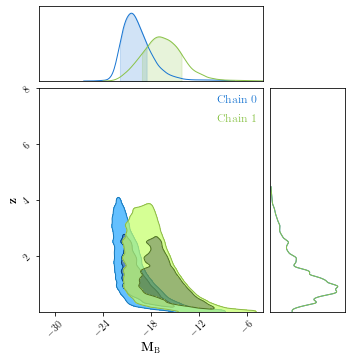

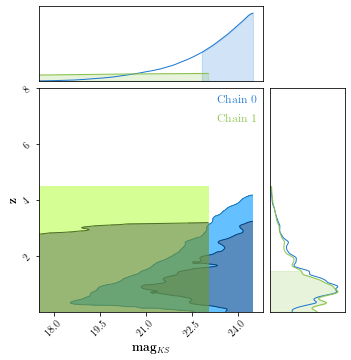

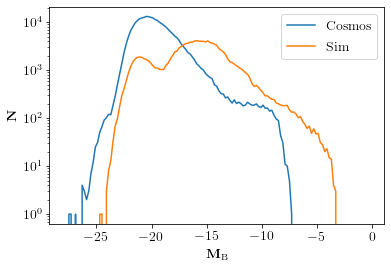

In [62]:
mask = np.logical_and(mask_cosmos, np.isfinite(cosmos_abs_mag)) #and np.isfinite(cosmos['HSC_i_FLUX_APER3']/cosmos['HSC_i_FLUXERR_APER3'])

c = ChainConsumer()
c.add_chain({r'\textbf{M$_\mathrm{B}$}': cosmos_abs_mag[mask], r'\textbf{z}': cosmos['photoz'][mask]})
c.add_chain({r'\textbf{M$_\mathrm{B}$}': M_sf[mask], r'\textbf{z}': cosmos['photoz'][mask]})
c.plotter.plot(figsize="column", display=True, extents=[(-32,-4), (0,8)])


c = ChainConsumer()
c.add_chain({r'\textbf{mag$_{KS}$}': cosmos['UVISTA_Ks_MAG_APER3'][mask_cosmos], 
             r'\textbf{z}': cosmos['photoz'][mask_cosmos]})
c.add_chain({r'\textbf{mag$_{KS}$}': m_vista_true_sf[:,3][mask_sim] + m_vista_sim_sf[:,3][mask_sim], 
             r'\textbf{z}': cosmos['photoz'][mask_sim]})
c.plotter.plot(figsize="column", display=True, extents=[(17.5,24.8), (0,8)])


bins_abs_mag = np.arange(-28, 0,0.2)
bin_centers_abs_mag = bins_abs_mag[:-1] + (bins_abs_mag[-1]-bins_abs_mag[0])/(2*len(bins_abs_mag))

hist_cosmos, _ = np.histogram(cosmos_abs_mag[mask_cosmos], bins=bins_abs_mag, density=False)
hist_sim, _ = np.histogram(M_sf[mask_sim] , bins=bins_abs_mag, density=False)

plt.plot(bin_centers_abs_mag, hist_cosmos, label='Cosmos')
plt.plot(bin_centers_abs_mag, hist_sim, label='Sim')
plt.legend()
plt.xlabel(r'\textbf{M$_\mathrm{B}$}')
plt.ylabel(r'\textbf{N}')
plt.yscale('log')
plt.show()